In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/assignment-2/training-c.csv
/kaggle/input/assignment-2/training-c/c17226.png
/kaggle/input/assignment-2/training-c/c22112.png
/kaggle/input/assignment-2/training-c/c05587.png
/kaggle/input/assignment-2/training-c/c13867.png
/kaggle/input/assignment-2/training-c/c12614.png
/kaggle/input/assignment-2/training-c/c08374.png
/kaggle/input/assignment-2/training-c/c07533.png
/kaggle/input/assignment-2/training-c/c23400.png
/kaggle/input/assignment-2/training-c/c08104.png
/kaggle/input/assignment-2/training-c/c15412.png
/kaggle/input/assignment-2/training-c/c09984.png
/kaggle/input/assignment-2/training-c/c14463.png
/kaggle/input/assignment-2/training-c/c22558.png
/kaggle/input/assignment-2/training-c/c01118.png
/kaggle/input/assignment-2/training-c/c08625.png
/kaggle/input/assignment-2/training-c/c07074.png
/kaggle/input/assignment-2/training-c/c24244.png
/kaggle/input/assignment-2/training-c/c19970.png
/kaggle/input/assignment-2/training-c/c22602.png
/kaggle/input/assignment-2/

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import ImageFile, Image
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset, Dataset

In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv('/kaggle/input/assignment-2/training-c.csv')
df.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,c00000.png,Scan_280_digit_6_num_7.png,280,6,OngkoDB,Buet_Backpropers,training-c
1,c00001.png,Scan_29_digit_1_num_1.png,29,1,OngkoDB,Buet_Backpropers,training-c
2,c00002.png,Scan_131_digit_3_num_1.png,131,3,OngkoDB,Buet_Backpropers,training-c
3,c00003.png,Scan_160_digit_2_num_2.png,160,2,OngkoDB,Buet_Backpropers,training-c
4,c00004.png,Scan_202_digit_7_num_0.png,202,7,OngkoDB,Buet_Backpropers,training-c


In [4]:
df = df[['filename', 'digit']]
df.head()

,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [5]:
class Handwritten_Digit_Dataset(Dataset):
  def __init__(self, data, dir, transform = None):
    self.data = data
    self.dir = dir
    self.transform = transform
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    path = self.dir + "/" + item[0]
    image = Image.open(path).convert('L')
    label = item[1]
    
    if self.transform is not None:
      image = self.transform(image)
      
    return image, label

In [6]:
mean = [0.5,]
std = [0.5,]
train_transform = transforms.Compose([
                                      transforms.Resize(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])
                                      ])

test_transform = transforms.Compose([
                                      transforms.Resize(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

dir = '/kaggle/input/assignment-2/training-c'
dataset  = Handwritten_Digit_Dataset(df, dir, train_transform)

print("Total Images: ",len(dataset))

Total Images:  24298


In [7]:
BATCH_SIZE = 64

train_set, test_set = torch.utils.data.random_split(dataset, [19438, 4860]) #80%
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Train Images: ",len(train_set))
print("Test Images: ",len(test_set))
print("Train Batch: ",len(train_loader))

Train Images:  19438
Test Images:  4860
Train Batch:  304


In [8]:
# Hyperparameters
batch_size = 64
num_hidden = 1024
num_iters = 100000
learning_rate = 0.05
input_dim = 32*32
output_dim = 10
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [9]:
class DNN(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__() 
        
        self.fc1 = nn.Linear(input_size, num_hidden) 
        self.fc2 = nn.Linear(1024, 512) 
        self.fc3 = nn.Linear(512, 256) 
        self.fc4 = nn.Linear(256, 256) 
        self.out = nn.Linear(256, num_classes)
      
        #dropout to reduce overfitting
        #self.drop = nn.Dropout(0.25) 
      

    def forward(self, x):
        x=x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        #x = self.drop(x)

        return x

In [10]:
model = DNN(input_size=input_dim, num_classes=output_dim, num_hidden=num_hidden)
#Store in GPU
model.to(device)
print(model)
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

DNN(
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
stepcount = []
train_loss = []
train_loss2 = []
train_accuracy = []
test_accuracy = []
totalsteps = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter += 1
        #train_loss2 += loss.item()
        if iter % 200 == 0:  
            correct_test = 0
            total_test = 0

            for images, labels in test_loader:
                images = images.view(-1, input_dim).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                if torch.cuda.is_available():
                    correct_test += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct_test += (predicted == labels).sum()  

            accuracy_test = 100 * correct_test.item() / total_test

            train_loss.append(loss.item())
            test_accuracy.append(accuracy_test)
            
            totalsteps.append(iter)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy_test))
            accuracy_test = 0

Iteration: 200. Loss: 2.311436176300049. Accuracy: 9.135802469135802
Iteration: 400. Loss: 2.303804397583008. Accuracy: 10.493827160493828
Iteration: 600. Loss: 2.297300338745117. Accuracy: 13.806584362139917
Iteration: 800. Loss: 2.2963147163391113. Accuracy: 14.238683127572017
Iteration: 1000. Loss: 2.2629618644714355. Accuracy: 16.48148148148148
Iteration: 1200. Loss: 2.2716877460479736. Accuracy: 10.74074074074074
Iteration: 1400. Loss: 2.1839473247528076. Accuracy: 15.925925925925926
Iteration: 1600. Loss: 2.2335715293884277. Accuracy: 22.22222222222222
Iteration: 1800. Loss: 2.2193615436553955. Accuracy: 16.008230452674898
Iteration: 2000. Loss: 2.0909669399261475. Accuracy: 11.666666666666666
Iteration: 2200. Loss: 2.223440408706665. Accuracy: 20.0
Iteration: 2400. Loss: 2.22102952003479. Accuracy: 12.181069958847736
Iteration: 2600. Loss: 2.1578333377838135. Accuracy: 26.604938271604937
Iteration: 2800. Loss: 2.2086586952209473. Accuracy: 25.123456790123456
Iteration: 3000. Los

In [12]:
%cd /kaggle/working

/kaggle/working


In [13]:
Path='./EX2.pkl'
pt = './EX2.pth'
torch.save(model.state_dict(), Path)
torch.save(model.state_dict(), pt)

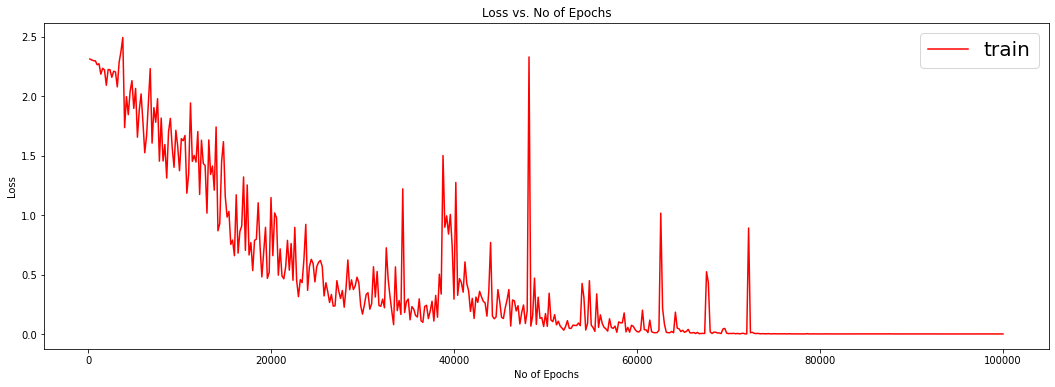

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.title("Loss vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.plot(totalsteps, train_loss,'r-', label="train")
#plt.plot(range(NUM_EPOCHS), val_loss_hist,'b-', label="val")
#plt.ylim((2.2,2.4))
plt.legend(prop={'size': 20}, loc='upper right')

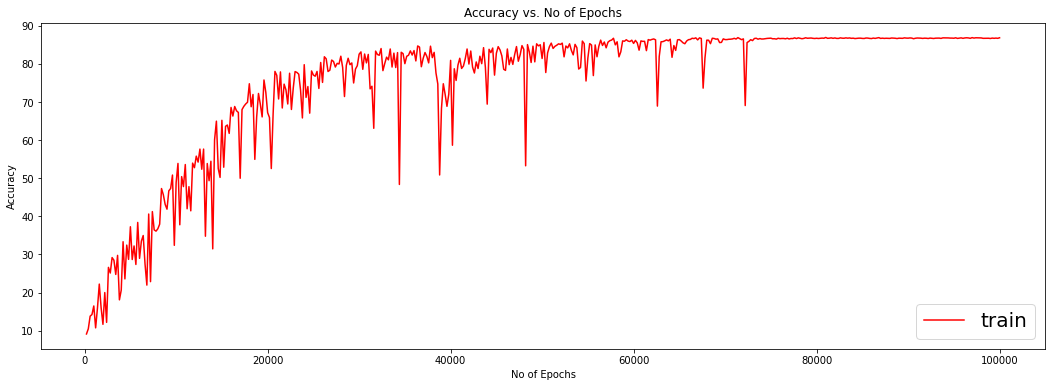

In [15]:
plt.figure(figsize=(18,6))
plt.title("Accuracy vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.plot(totalsteps, test_accuracy,'r-', label="train")
#plt.ylim((0,100))
plt.legend(prop={'size': 20}, loc='lower right')
plt.show()

In [16]:
%ls

EX2.pkl  EX2.pth  __notebook__.ipynb
